## Plotting amplicon panel summary statistics
----


#### Required inputs:
*General*
- GFF
- FASTA

*Panel specific*
- BAM file for 3d7 or Dd2
- BED file of amplicon boundaries
- BED file of CDS boundaries for amplicon



#### Questions:
- How to visualise 16plex?

In [25]:
import os
import numpy as np
import pandas as pd
import pysam

from dataclasses import dataclass

from nomadic.lib.process_gffs import load_gff
from nomadic.lib.process_gffs import add_gff_fields
from nomadic.truthset.fasta import load_haplotype_from_fasta
from nomadic.lib.statistics import get_homopolymer_runs, calc_sliding_percentGC

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams["figure.dpi"] = 100

### Settings

In [26]:
output_dir = "figures/fig1_visualise-reads"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### General files

In [38]:
gff_path = "../resources/plasmodb/52/PlasmoDB-52_Pfalciparum3D7.gff"
fasta_path = "../resources/plasmodb/52/PlasmoDB-52_Pfalciparum3D7_Genome.fasta"

### Amplicon files

In [39]:
focus_barcode = 1 # 3d7

*NOMADS8*

In [40]:
# BAM information
expt_dir8 = "../experiments/2021-11-14_strain-validation-flongle-lfb"
bam_dir_n8 = f"{expt_dir8}/nomadic/guppy/hac/single_end/barcodes/barcode{focus_barcode:02d}/target-extraction"

# Multiplex information
mplx_primers_n8 = "../resources/multiply/multiplexes/multiplex.03.greedy.csv"
mplx_amp_n8 = "../resources/multiply/multiplexes/multiplex.03.greedy.bed"
mplx_cds_n8 = "../resources/truthsets/beds/multiplex.03.greedy.cds_only.bed"

*NOMADS16*

In [41]:
expt_dir16 = "../experiments/2021-11-20_strain-validation-16plex/"

### Functions

In [42]:
@dataclass
class AlignmentPlotData:
    read_id: str
    ref_start: int
    ref_end: int
    ref_name: str
    query_alignment_length: int
    mean_qscore: float
    forward: bool

    @classmethod
    def from_pysam_aligned_segment(cls, pysam_segment: pysam.AlignedSegment):
        """
        Extract alignment data for plotting from an aligned `pysam` segment

        """
        # Compute mean quality score
        qscores = np.array(pysam_segment.query_qualities)
        mean_qscore = qscores.mean() if qscores.shape else None

        return cls(
            read_id=pysam_segment.query_name,
            ref_start=pysam_segment.reference_start,
            ref_end=pysam_segment.reference_end,
            ref_name=pysam_segment.reference_name,
            query_alignment_length=pysam_segment.query_alignment_length,
            mean_qscore=mean_qscore,
            forward=pysam_segment.is_forward,
        )

In [43]:
def load_bam_info(bam_path):
    with pysam.AlignmentFile(bam_path, "r") as bam:
        bam_df = pd.DataFrame(
            [
                AlignmentPlotData.from_pysam_aligned_segment(alignment)
                for alignment in bam
            ]
        )
    return bam_df

## Load core data

In [44]:
# Load GFF file
gff = load_gff(gff_path)
gff.rename({"seqid": "seqname"}, axis=1, inplace=True)

## Load panel information

### Primer information
- Primarily used to map gene IDs to amplicon names

In [51]:
primer_df = pd.read_csv(mplx_primers_n8)

In [68]:
name_to_id = dict(zip(primer_df["gene_name"], primer_df["target"]))
name_to_id = {
    k if k != "MDR1part" else "MDR1" : v
    for k, v in name_to_id.items()
}
target_names = list(name_to_id.keys())
id_to_name = {v: k for k, v in name_to_id.items()}

### Amplicon sizes

In [69]:
# AMPLICON N8
# Load
mplx_amp_df_n8 = pd.read_csv(mplx_amp_n8,
                             sep="\t",
                             names=["chrom", "start", "end", "target_name"])

# Annotate
mplx_amp_df_n8.insert(
    3,
    "length",
    mplx_amp_df_n8["end"] - mplx_amp_df_n8["start"]
)
mplx_amp_df_n8["target_name"] = [
    t if t != "MDR1part" else "MDR1"
    for t in mplx_amp_df_n8["target_name"]
]

# Sort
mplx_amp_df_n8.sort_values("target_name", ascending=True, inplace=True)

### Coding sequence sizes

In [70]:
# CODING SEQUENCE FOR N8
# Load
mplx_cds_n8_df = pd.read_csv(mplx_cds_n8,
                             sep="\t",
                             names=["chrom", "start", "end", "exon_name"])

# Annotate
mplx_cds_n8_df.insert(
    0,
    "target_id",
    [e.split(".")[0] for e in mplx_cds_n8_df["exon_name"]]
)
mplx_cds_n8_df.insert(
    3,
    "length",
    mplx_cds_n8_df["end"] - mplx_cds_n8_df["start"]
)

# Create summary
mplx_cds_df_n8 = (mplx_cds_n8_df
                  .groupby("target_id")
                  .agg(
                      cds_start=pd.NamedAgg("start", min),
                      cds_end=pd.NamedAgg("end", max)
                  )
                  .reset_index()
                 )
mplx_cds_df_n8.insert(
    3,
    "length",
    mplx_cds_df_n8["cds_end"] - mplx_cds_df_n8["cds_start"]
)
mplx_cds_df_n8.insert(
    1,
    "target_name",
    [id_to_name[i] for i in mplx_cds_df_n8["target_id"]]
)

### Read length information

In [129]:
bam_dfs = []
target_overlaps = {}
for target_name in name_to_id:
    # Load BAM file
    bam_path = f"{bam_dir_n8}/reads.target.{target_name}.bam"
    bam_df = load_bam_info(bam_path)
    
    # Annotate
    bam_df.insert(0, "target_name", target_name)
    
    # Store
    print(f"  Loaded {bam_df.shape[0]} reads for {target_name}...")
    bam_dfs.append(bam_df)
    
    # Compute number of reads overlapping ORF
    target_info = mplx_cds_df_n8.query("target_name == @target_name").squeeze()
    left_outside = bam_df["ref_start"] <= target_info["cds_start"]
    right_outside = bam_df["ref_end"] >= target_info["cds_end"]
    outside = left_outside & right_outside
    per_overlap = 100 * outside.sum() / outside.shape[0]
    target_overlaps[target_name] = per_overlap
    
bam_n8_df = pd.concat(bam_dfs)
bam_n8_df.sort_values("target_name", ascending=True, inplace=True)
print("Done.")

  Loaded 1984 reads for MDR1...
  Loaded 635 reads for MSP2...
  Loaded 1565 reads for DHFR...
  Loaded 246 reads for CRT1...
  Loaded 1507 reads for DHPS...
  Loaded 1941 reads for K13...
  Loaded 828 reads for PMI...
  Loaded 636 reads for PMIII...
Done.


### Sequecing complexity information

In [72]:
seq_comp = {
    "target_name": [],
    "per_at": [],
    "hp_runs": []
}
print("Loading sequence complexity information...")
for target_name in target_names:
    # Extract region
    r = mplx_amp_df_n8.query("target_name == @target_name").squeeze()
    region = f"{r['chrom']}:{r['start']}-{r['end']}"
    
    # Load sequence
    seq = load_haplotype_from_fasta(fasta_path, region=region)
    print(f"  Loaded sequence of {len(seq)}bp for {target_name}...")
    
    # Compute summary statistics
    hp_runs = get_homopolymer_runs(seq)
    per_at = 1 - calc_sliding_percentGC(seq, window=20)
    N_bp = hp_runs.shape[0]
    
    # Store
    seq_comp["target_name"].extend([target_name]*N_bp)
    seq_comp["per_at"].extend(per_at.tolist())
    seq_comp["hp_runs"].extend(hp_runs.tolist())
seq_comp_df = pd.DataFrame(seq_comp)
seq_comp_df.sort_values("target_name", ascending=True, inplace=True)
print("Done.")

Loading sequence complexity information...
  Loaded sequence of 3774bp for MDR1...
  Loaded sequence of 3721bp for MSP2...
  Loaded sequence of 3464bp for DHFR...
  Loaded sequence of 3875bp for CRT1...
  Loaded sequence of 3657bp for DHPS...
  Loaded sequence of 3827bp for K13...
  Loaded sequence of 3102bp for PMI...
  Loaded sequence of 3469bp for PMIII...
Done.


In [73]:
# Create a homopolymer summary data frame
hp_df = \
(seq_comp_df
 .groupby("target_name")
 .agg(
     n = pd.NamedAgg("hp_runs", len),
     hp_3 = pd.NamedAgg("hp_runs", lambda x: sum(x >= 3)/len(x)),
     hp_4 = pd.NamedAgg("hp_runs", lambda x: sum(x >= 4)/len(x)),
     hp_5 = pd.NamedAgg("hp_runs", lambda x: sum(x >= 5)/len(x)),
     hp_6 = pd.NamedAgg("hp_runs", lambda x: sum(x >= 6)/len(x)), 
     hp_9 = pd.NamedAgg("hp_runs", lambda x: sum(x >= 9)/len(x)), 
 )
 .reset_index()
)
hp_df.sort_values("target_name", ascending=True, inplace=True)

## Plot

In [83]:
mplx_cds_df_n8

,target_id,target_name,cds_start,cds_end,length
0,PF3D7_0206800,MSP2,273689,274507,818
1,PF3D7_0417200,DHFR,748088,749914,1826
2,PF3D7_0523000,MDR1,957890,962149,4259
3,PF3D7_0709000,CRT1,403222,406317,3095
4,PF3D7_0810800,DHPS,548200,550616,2416
5,PF3D7_1343700,K13,1724817,1726997,2180
6,PF3D7_1407900,PMI,288297,289655,1358
7,PF3D7_1408100,PMIII,297468,298823,1355


In [139]:
from matplotlib.patches import Rectangle

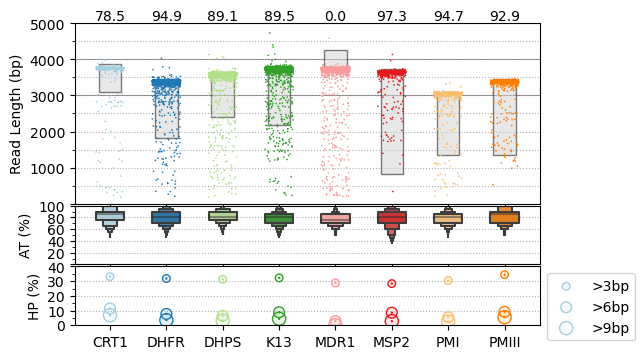

In [149]:
# Size figure
width = 6
height = 4
fig = plt.figure(figsize=(width, height))
fig.subplots_adjust(hspace=0.15)

# Prepare grid
gs = GridSpec(nrows=20, ncols=1)
ax_rl = plt.subplot(gs[0:12])
ax_at = plt.subplot(gs[12:16], sharex=ax_rl)
ax_hp = plt.subplot(gs[16:20], sharex=ax_rl)

# READ LENGTHS
ax = ax_rl
# Plot
sns.stripplot(
    x=bam_n8_df["target_name"],
    y=bam_n8_df["query_alignment_length"],
    palette=sns.color_palette("Paired", 8),
    jitter=0.25,
    s=1.2,
    ax=ax
)
# Amplicons
box_wd = 0.2
for ix, target_name in enumerate(mplx_amp_df_n8["target_name"]):
    amp_length = mplx_amp_df_n8.query("target_name == @target_name").squeeze()["length"]
    cds_length = mplx_cds_df_n8.query("target_name == @target_name").squeeze()["length"]
    height = amp_length - cds_length
    rectangle = Rectangle(
        xy=(ix-0.2, cds_length),
        width=0.2*2,
        height=height,
        ec="black",
        fc="lightgrey",
        alpha=0.5,
        lw=1
    )
    ax.add_artist(rectangle)
    


# ax.scatter(
#     x=mplx_amp_df_n8["target_name"],
#     y=mplx_amp_df_n8["length"],
#     marker="v",
#     lw=1,
#     color="black",
#     s=30,
#     zorder=3,
#     label="Amplicon"
# )
# # CDS
# ax.scatter(
#     x=mplx_cds_df_n8["target_name"],
#     y=mplx_cds_df_n8["length"],
#     marker="x",
#     color="black",
#     s=30,
#     zorder=3,
#     label="ORF"
# )
# ax.legend(bbox_to_anchor=(1, 1), loc="upper left", title="Length (bp)")



# Limits
ax.set_ylim((0, 5000))

# Ticks
ax.yaxis.set_minor_locator(plt.MultipleLocator(500))

# Lines
ax.set_axisbelow(True) 
ax.axhline(y=3000, zorder=-10, color='grey', lw=0.75)
ax.axhline(y=4000, zorder=-10, color='grey', lw=0.75)
ax.grid(axis='y', ls='dotted', which='both')

# Label
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, ix: int(val) if val != 0 else None))
ax.set_ylabel("Read Length (bp)")

# Annotate
for ix, target_name in enumerate(mplx_amp_df_n8["target_name"]):
    per = target_overlaps[target_name]
    ax.annotate(
        xy=(ix, ax.get_ylim()[1]),
        ha="center", va="bottom",
        text=f"{per:.1f}"
    )


# AT PERCENTAGE
ax = ax_at
# Plot
sns.boxenplot(
    x=seq_comp_df["target_name"],
    y=seq_comp_df["per_at"],
    palette=sns.color_palette("Paired", 8),
    width=0.5,
    showfliers=False,
    ax=ax
)

# Limit
ax.set_ylim((0, 1.0))

# Lines
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.set_axisbelow(True) 
ax.grid(ls='dotted', axis='y')

# Labels
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, ix: int(100*val) if val != 0 else None))
ax.set_ylabel("AT (%)")

# HP STATISTICS
ax = ax_hp
# Plot
szs = [3, 6, 9]
for sz in szs:
    ax.scatter(
        x=hp_df["target_name"],
        y=hp_df[f"hp_{sz}"],
        s=sz*10,
        fc=[c + (0.1,) for c in sns.color_palette("Paired", 8)],
        ec=sns.color_palette("Paired", 8),
        lw=1,
        label=f">{sz}bp"
    )
    ax.scatter(
        x=hp_df["target_name"],
        y=hp_df[f"hp_{sz}"],
        marker=".",
        s=2,
        c=sns.color_palette("Paired", 8),
        lw=1
    )

# Limit
ax.set_ylim((0, 0.4))

# Lines
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.set_axisbelow(True) 
ax.grid(ls='dotted', axis='y')

# Label
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, ix: int(100*val)))
ax.set_ylabel("HP (%)")

# Legend
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")

fig.savefig(f"{output_dir}/summary_stats.n8.box.pdf")

- This looks decent

In [143]:
mplx_cds_df_n8

,target_id,target_name,cds_start,cds_end,length
0,PF3D7_0206800,MSP2,273689,274507,818
1,PF3D7_0417200,DHFR,748088,749914,1826
2,PF3D7_0523000,MDR1,957890,962149,4259
3,PF3D7_0709000,CRT1,403222,406317,3095
4,PF3D7_0810800,DHPS,548200,550616,2416
5,PF3D7_1343700,K13,1724817,1726997,2180
6,PF3D7_1407900,PMI,288297,289655,1358
7,PF3D7_1408100,PMIII,297468,298823,1355


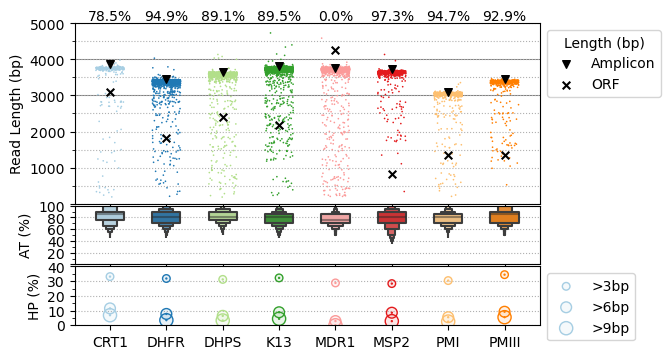

In [147]:
# Size figure
width = 6
height = 4
fig = plt.figure(figsize=(width, height))
fig.subplots_adjust(hspace=0.15)

# Prepare grid
gs = GridSpec(nrows=20, ncols=1)
ax_rl = plt.subplot(gs[0:12])
ax_at = plt.subplot(gs[12:16], sharex=ax_rl)
ax_hp = plt.subplot(gs[16:20], sharex=ax_rl)

# READ LENGTHS
ax = ax_rl
# Plot
sns.stripplot(
    x=bam_n8_df["target_name"],
    y=bam_n8_df["query_alignment_length"],
    palette=sns.color_palette("Paired", 8),
    jitter=0.25,
    s=1.2,
    ax=ax
)
# Amplicons
ax.scatter(
    x=mplx_amp_df_n8["target_name"],
    y=mplx_amp_df_n8["length"],
    marker="v",
    lw=1,
    color="black",
    s=30,
    zorder=3,
    label="Amplicon"
)
# CDS
ax.scatter(
    x=mplx_cds_df_n8["target_name"],
    y=mplx_cds_df_n8["length"],
    marker="x",
    color="black",
    s=30,
    zorder=3,
    label="ORF"
)
ax.legend(bbox_to_anchor=(1, 1), loc="upper left", title="Length (bp)")



# Limits
ax.set_ylim((0, 5000))

# Ticks
ax.yaxis.set_minor_locator(plt.MultipleLocator(500))

# Lines
ax.set_axisbelow(True) 
ax.axhline(y=3000, zorder=-10, color='grey', lw=0.75)
ax.axhline(y=4000, zorder=-10, color='grey', lw=0.75)
ax.grid(axis='y', ls='dotted', which='both')

# Label
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, ix: int(val) if val != 0 else None))
ax.set_ylabel("Read Length (bp)")

# Annotate
for ix, target_name in enumerate(mplx_amp_df_n8["target_name"]):
    per = target_overlaps[target_name]
    ax.annotate(
        xy=(ix, ax.get_ylim()[1]),
        ha="center", va="bottom",
        text=f"{per:.1f}%"
    )


# AT PERCENTAGE
ax = ax_at
# Plot
sns.boxenplot(
    x=seq_comp_df["target_name"],
    y=seq_comp_df["per_at"],
    palette=sns.color_palette("Paired", 8),
    width=0.5,
    showfliers=False,
    ax=ax
)

# Limit
ax.set_ylim((0, 1.0))

# Lines
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.set_axisbelow(True) 
ax.grid(ls='dotted', axis='y')

# Labels
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, ix: int(100*val) if val != 0 else None))
ax.set_ylabel("AT (%)")

# HP STATISTICS
ax = ax_hp
# Plot
szs = [3, 6, 9]
for sz in szs:
    ax.scatter(
        x=hp_df["target_name"],
        y=hp_df[f"hp_{sz}"],
        s=sz*10,
        fc=[c + (0.1,) for c in sns.color_palette("Paired", 8)],
        ec=sns.color_palette("Paired", 8),
        lw=1,
        label=f">{sz}bp"
    )
    ax.scatter(
        x=hp_df["target_name"],
        y=hp_df[f"hp_{sz}"],
        marker=".",
        s=2,
        c=sns.color_palette("Paired", 8),
        lw=1
    )

# Limit
ax.set_ylim((0, 0.4))

# Lines
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.set_axisbelow(True) 
ax.grid(ls='dotted', axis='y')

# Label
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda val, ix: int(100*val)))
ax.set_ylabel("HP (%)")

# Legend
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")

fig.savefig(f"{output_dir}/summary_stats.n8.pdf")